In [ ]:
"""
Validation of open-gira power outage model
This notebook compares modelled and observed customer disconnected estimates
Observed data are collated media and goverment reports (CSV files in validation/)
Modelled data are exposure_by_country.nc for the whole IBTrACS storm set
"""

In [14]:
import os
from glob import glob

import geopandas as gpd
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
# model outputs
root_path = "/home/fred/projects/open_gira/open-gira/"
tracks_path = os.path.join(root_path, "results/input/IBTrACS/processed/v4.geoparquet")
targets_path = os.path.join(root_path, "results/power/targets_with_iso_a3.geoparquet")
exposure_path = os.path.join(root_path, "results/power/by_storm_set/IBTrACS/exposure_by_country.nc")

# validation data
# https://www.un.org/development/desa/pd/data/household-size-and-composition
household_path = os.path.join(root_path, "undesa_pd_2022_hh-size-composition.xlsx")
# https://gist.githubusercontent.com/tadast/8827699/raw/f5cac3d42d16b78348610fc4ec301e9234f82821/countries_codes_and_coordinates.csv
iso_codes = os.path.join(root_path, "iso_codes.csv")
# see source column
outage_paths = glob(os.path.join(root_path, "validation/*.csv"))

In [5]:
# read iso numeric to alpha table
rename_dict = {
    "Country": "name",
    "Alpha-2 code": "iso_a2",
    "Alpha-3 code": "iso_a3",
    "Numeric code": "iso_num"
}
iso = pd.read_csv(iso_codes, usecols=rename_dict.keys())
iso = iso.rename(columns=rename_dict)
# strip out quotes
for c in iso.columns:
    iso[c] = iso[c].str.replace('"', "").str.strip()
iso.iso_num = iso.iso_num.astype(int)

In [6]:
# read household size data
rename_dict = {
    "ISO Code": "iso_num",
    "Reference date (dd/mm/yyyy)": "ref_date",
    "Average household size (number of members)": "mean_household_pop"
}
hh = pd.read_excel(household_path, sheet_name="HH size and composition 2022", header=4, usecols=rename_dict.keys())
hh = hh.rename(columns=rename_dict)
hh.ref_date = pd.to_datetime(hh.ref_date, dayfirst=True)
# any non-numeric value -> NaN (some '..' placeholders in excel data)
hh["mean_household_pop"] = pd.to_numeric(hh["mean_household_pop"], errors="coerce")

# discard all but most recent entry for each territory
hh = hh.sort_values(["ref_date"], ascending=False).drop_duplicates("iso_num", keep="first")

# merge in iso alpha ids (will permit join with outage data)
hh = hh.merge(iso, how="left", on="iso_num")

In [7]:
# now compare population_affected with the exposure_by_country.nc data
ds = xr.open_dataset(exposure_path).rename({"country": "country_iso_a3"})

by_threshold = {}
for threshold in ds.threshold.values:

    # storm loop
    by_storm = {os.path.basename(p).split(".")[0]: pd.read_csv(p) for p in sorted(outage_paths)}
    for event_id, obs in by_storm.items():
            
        obs = obs.rename(columns={"country_iso_a3": "iso_a3"}).merge(hh, how="left", on="iso_a3")

        for i in range(len(obs)):
            # gap-fill the population_affected numbers where we have customers_affected only
            if pd.isna(obs.loc[i, "population_affected"]):
                by_storm[event_id].loc[i, "population_affected"] = \
                    obs.loc[i, "customers_affected"] * obs.loc[i, "mean_household_pop"]

        # take the largest estimate for each country (we assume reports underestimate outages)
        by_storm[event_id] = by_storm[event_id].groupby("country_iso_a3").max()
        by_storm[event_id] = by_storm[event_id][["population_affected"]]
        by_storm[event_id] = by_storm[event_id].rename(columns={"population_affected": "observed"})

        try:
            # select model data for given storm and threshold
            mod = ds.customers_affected.sel(dict(event_id=event_id, threshold=threshold)).to_pandas()
        except KeyError:
            # storm has no modelled results
            continue

        # non-zero modelled customers_affected (really population affected, should change this name!)
        mod = mod[mod > 0]
        mod.name = "modelled"
        by_storm[event_id] = by_storm[event_id].join(mod)
        by_storm[event_id]["error"] = \
            by_storm[event_id].modelled - by_storm[event_id].observed
        by_storm[event_id]["ratio"] = \
            by_storm[event_id].modelled / by_storm[event_id].observed
        by_storm[event_id]["error_norm"] = \
            by_storm[event_id].error / by_storm[event_id].observed

    concat = pd.concat(by_storm)
    concat.index.names = ["event_id", "country_iso_a3"]
    by_threshold[threshold] = concat

# all data with a 3 level multi-index
data = pd.concat(by_threshold, names=["threshold", "event_id", "country_iso_a3"])

In [8]:
def categorical_cmap(cmap_name: str, categories: list) -> dict[str: tuple[float]]:
    scalar_mappable = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(0, 1), cmap_name)
    return {code: scalar_mappable.to_rgba(i / len(categories)) for i, code in enumerate(categories)}

# create some colourmaps and persist between plots

# make a country colormap
countries = sorted(set(data.index.get_level_values("country_iso_a3").values))
country_cmap = categorical_cmap("tab20c", countries)

# make a cmap for wind speed thresholds
thresholds = sorted(set(data.index.get_level_values("threshold").values))
wind_cmap = categorical_cmap("plasma", thresholds)

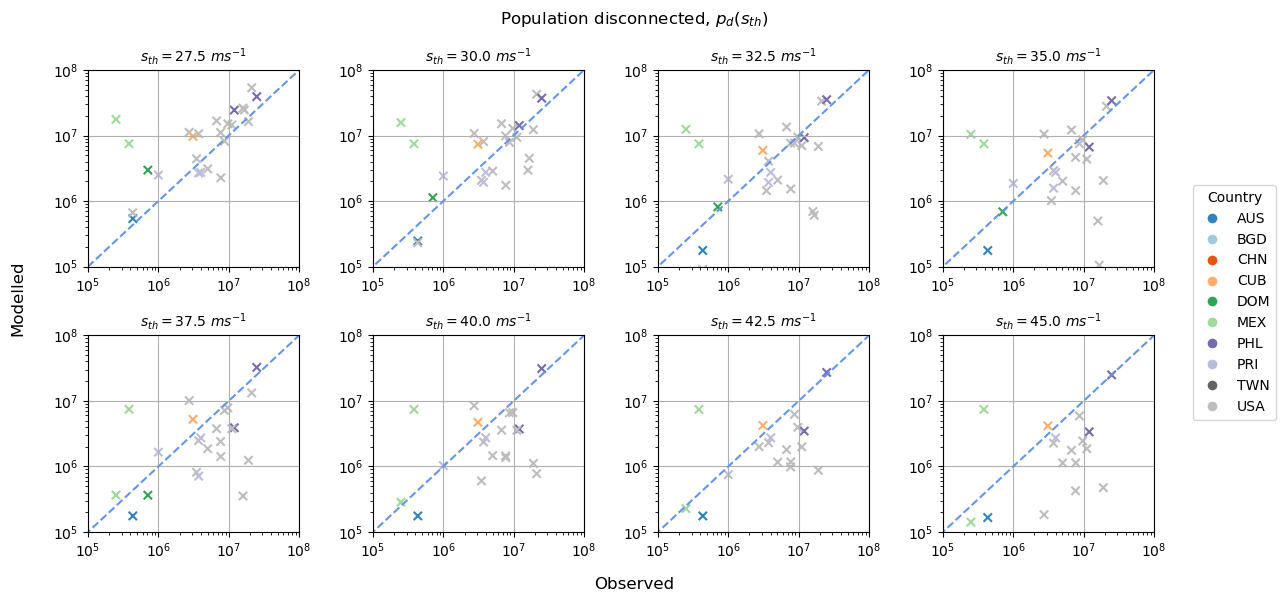

In [9]:
# scatter plot modelled vs. observed by threshold

n = len(thresholds)
ncols = min([n, 4])
nrows = (n // ncols) + (n % ncols)
f, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3 + 2.5 * ncols, 2 + 2 * nrows), squeeze=False)

for row in range(nrows):
    for col in range(ncols):

        i = col + (row * ncols)
        ax = axes[row, col]
        
        if i < n:
            threshold = thresholds[i]
            df = data.loc[threshold, :, :]

            # build a list of RGBA values the same length as the data
            colours = [country_cmap[value] for value in df.index.get_level_values("country_iso_a3").values]

            ax.scatter(df.observed, df.modelled, marker="x", c=colours)
            x = np.linspace(0, 10 * max(df.observed), 100)
            ax.plot(x, x, ls="--", c="cornflowerblue")
            ax.grid()
            ax.set_title(f"$s_{{th}} = {threshold} \ m s^{{-1}}$", size=10)
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.set_xlim(1E5, 1E8)
            ax.set_ylim(1E5, 1E8)

        # disable any axes we don't need
        else:
            ax.set_axis_off()

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in country_cmap.items() if isinstance(k, str)]
ax.legend(title='Country', handles=handles, bbox_to_anchor=(1.15, 1.8))
    
f.supxlabel("Observed")
f.supylabel("Modelled")
f.suptitle("Population disconnected, $p_{d}(s_{th})$")

plt.subplots_adjust(bottom=0.11, top=0.88, left=0.08, right=0.9, hspace=0.35, wspace=0.35)

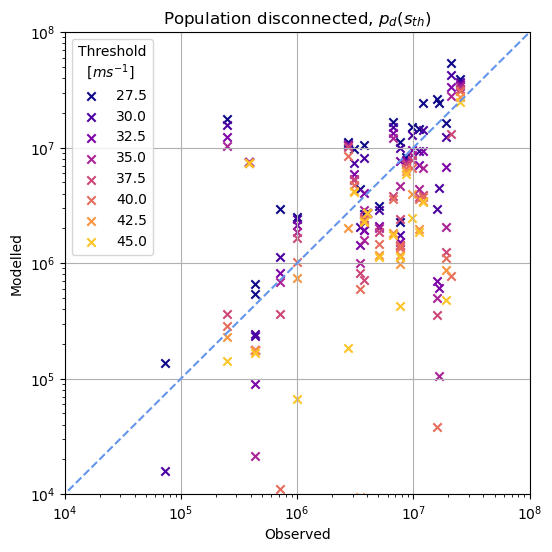

In [10]:
# scatter plot modelled vs. observed by threshold (same plot)

f, ax = plt.subplots(figsize=(6, 6))
    
for threshold in thresholds:
    df = data.loc[threshold, :, :]
    ax.scatter(df.observed, df.modelled, marker="x", label=threshold, color=wind_cmap[threshold])
    
x = np.linspace(0, 10 * max(data.observed), 100)
ax.plot(x, x, ls="--", c="cornflowerblue")
ax.grid()
ax.set_title("Population disconnected, $p_{d}(s_{th})$")
ax.set_xlabel("Observed")
ax.set_ylabel("Modelled")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1E4, 1E8)
ax.set_ylim(1E4, 1E8)
ax.legend(title="Threshold\n  $[m s^{{-1}}]$")

(-1.5, 4.0)

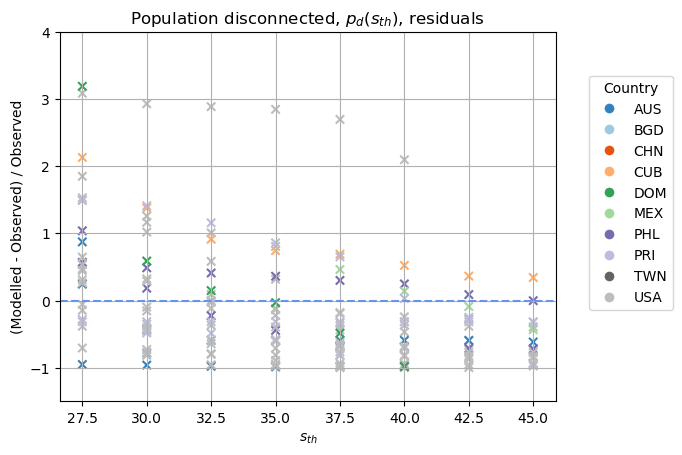

In [11]:
# scatter plot residual as a function of threshold

df = data["error_norm"].reset_index(["threshold", "country_iso_a3"])
colours = [country_cmap[value] for value in df.country_iso_a3.values]

f, ax = plt.subplots()
ax.scatter(df.threshold, df.error_norm, c=colours, label="Country", marker="x")
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in country_cmap.items() if isinstance(k, str)]
ax.legend(title='Country', handles=handles, bbox_to_anchor=(1.25, 0.9))
ax.grid()
ax.axhline(0, ls="--", c="cornflowerblue")
ax.set_xlabel("$s_{th}$")
ax.set_ylabel("(Modelled - Observed) / Observed")
ax.set_title("Population disconnected, $p_{d}(s_{th})$, residuals")
ax.set_ylim(-1.5, 4)

# N.B. a couple of values are more more than 400% out, therefore out of plot area
# -1, worst possible score (model 100% underestimated)
# 0, perfect score
# + valued, progressively greater model overestimate

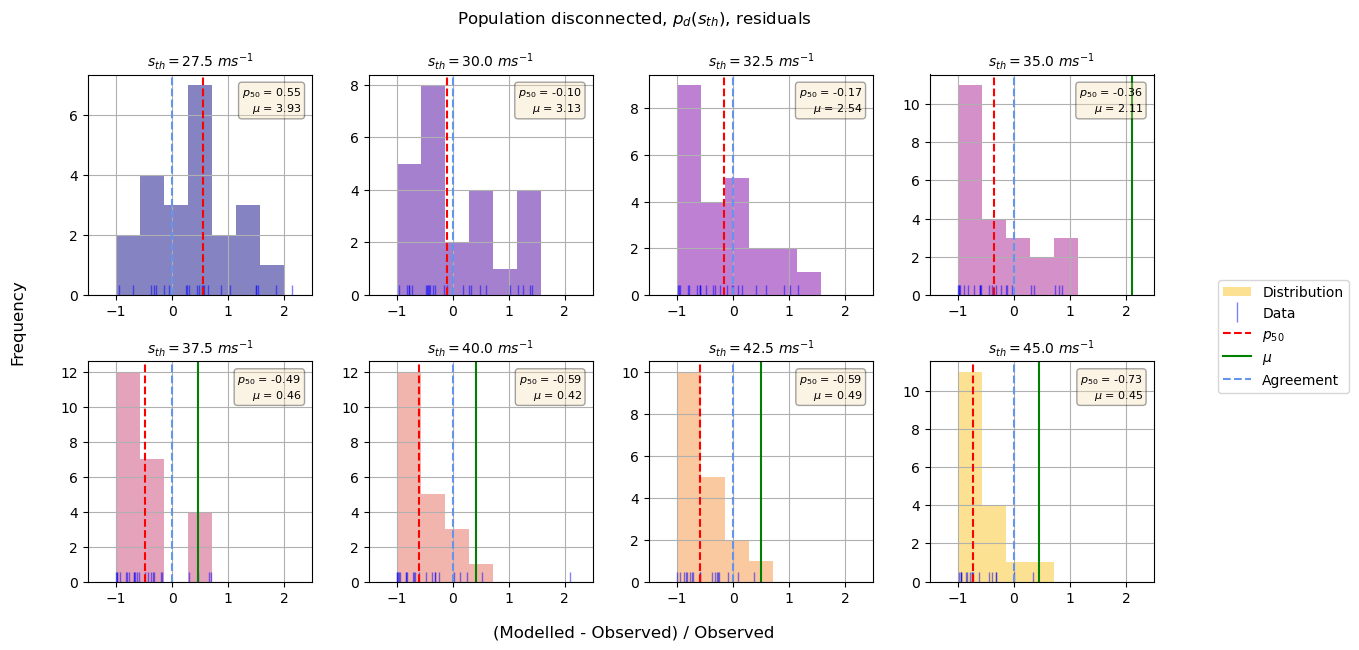

In [12]:
# plot residual distributions by threshold

n = len(thresholds)
ncols = min([n, 4])
nrows = (n // ncols) + (n % ncols)
f, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3 + 2.5 * ncols, 2 + 2.25 * nrows), squeeze=False)

bins = np.linspace(-1, 2, 8)

for row in range(nrows):
    for col in range(ncols):

        i = col + (row * ncols)
        ax = axes[row, col]
        if i < n:
            threshold = thresholds[i]

            error_norm = data.loc[threshold, :, :].error_norm

            ax.grid()

            # distribution
            ax.hist(
                error_norm,
                bins=bins,
                alpha=0.5,
                label="Distribution",
                facecolor=wind_cmap[threshold]
            )

            # rug plot
            ax.plot(error_norm, np.zeros(len(error_norm)), 'b|', ms=15, alpha=0.5, label="Data")

            # average measures
            mean = np.nanmean(error_norm)
            median = np.nanmedian(error_norm)
            ax.axvline(median, ls="--", c="red", label=r"$p_{50}$")
            ax.axvline(mean, ls="-", c="green", label=r"$\mu$")
            
            # target
            ax.axvline(0, ls="--", c="cornflowerblue", label="Agreement")

            ax.set_xlim(-1.5, 2.5)
            ax.set_title(f"$s_{{th}} = {threshold} \ m s^{{-1}}$", size=10)

            props = dict(boxstyle='round', facecolor='wheat', alpha=0.35)
            ax.text(
                0.95,
                0.95,
                "\n".join([f"$p_{{50}}$ = {median:.2f}", f"$\mu$ = {mean:.2f}"]),
                transform=ax.transAxes,
                fontsize=8,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=props
            )
            
        # disable any axes we don't need
        else:
            ax.set_axis_off()
    
ax.legend(bbox_to_anchor=(1.9, 1.4))

f.supxlabel("(Modelled - Observed) / Observed")
f.supylabel("Frequency")
f.suptitle("Population disconnected, $p_{d}(s_{th})$, residuals")

plt.subplots_adjust(bottom=0.1, top=0.88, left=0.08, right=0.9, hspace=0.3, wspace=0.25)

# note that the means are terribly skewed courtesy of a few outliers
# the modelled values for the two Mexican storms especially are significant overestimates   

Text(0, 0.5, 'Frequency')

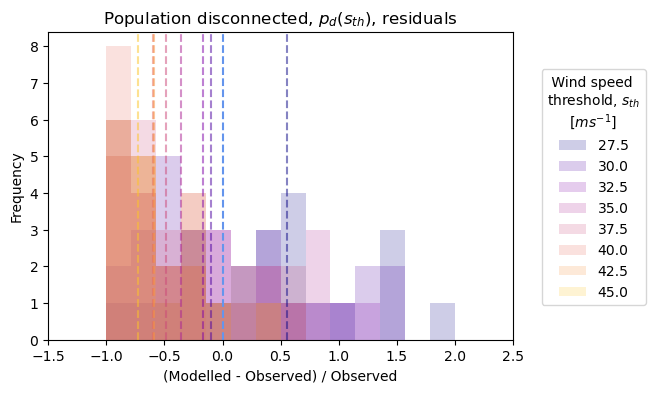

In [13]:
# over plot residual distributions by threshold

f, ax = plt.subplots(figsize=(6, 4))
for threshold in thresholds:
    
    error_norm = data.loc[threshold, :, :].error_norm
    ax.hist(
        error_norm,
        bins=np.linspace(-1, 2, 15),
        alpha=0.2,
        label=threshold,
        color=wind_cmap[threshold]
    )
    ax.axvline(np.nanmedian(error_norm), ls="--", c=wind_cmap[threshold], alpha=0.5)
    
ax.axvline(0, ls="--", c="cornflowerblue")
    
ax.set_xlim(-1.5, 2.5)
ax.legend(title=" Wind speed\nthreshold, $s_{th}$\n     $[m s^{-1}]$", bbox_to_anchor=(1.3, 0.9))
ax.set_title("Population disconnected, $p_{d}(s_{th})$, residuals")
ax.set_xlabel("(Modelled - Observed) / Observed")
ax.set_ylabel("Frequency")